# QuakeMigrate example - Icequake detection at the Rutford icestream

## Overview

This notebook contains another example showing how to run QuakeMigrate for icequake detection.

Here, we detail how to:
1. Create travel-time lookup tables for the example seismometer network
2. Run the detect stage to coalesce energy through time
3. Run the trigger stage to determine events above a threshold value
4. Run the locate stage to refine the earthquake location

In [8]:
from pyproj import Proj

import pandas as pd

import QMigrate.io as qio
import QMigrate.lut as qlut
from QMigrate.signal import QuakeScan, Trigger
from QMigrate.signal.onset import CentredSTALTAOnset, ClassicSTALTAOnset
from QMigrate.signal.pick import GaussianPicker

%matplotlib inline

In [2]:
# --- i/o paths ---
station_file = "./inputs/rutford_stations.txt"
data_in = "./inputs/mSEED"
lut_out = "./outputs/lut/icequake.LUT"
out_path = "./outputs/runs"
run_name = "icequake_example"

## 1. Create travel-time lookup tables (LUTs)

In [3]:
# --- Read in the station information file ---
stations = qio.stations(station_file)

# --- Define projections ---
cproj = Proj(proj="longlat", ellps="WGS84", datum="WGS84", no_defs=True)
gproj = Proj(proj="lcc", lon_0=-83.932, lat_0=-78.144, lat_1=-78.1, lat_2=-77.9,
             datum="WGS84", ellps="WGS84", units="m", no_defs=True)

# --- Create new LUT ---
# Cell count (x,y,z); cell size (x,y,z in metres)
lut = qlut.LUT(ll_corner=[-84.14853353566141, -78.18825429331356, -350.],
               ur_corner=[-83.71921885073093, -78.10003166259442, 3550],
               cell_size=[100., 100., 100.], grid_proj=gproj, coord_proj=cproj)

# --- Homogeneous LUT generation ---
vp = 3841
vs = 1970
qlut.compute(lut, stations, method="homogeneous", vp=vp, vs=vs)

# --- Save LUT ---
lut.save(lut_out)

Computing homogeneous travel-time lookup table - 1 of 10
Computing homogeneous travel-time lookup table - 2 of 10
Computing homogeneous travel-time lookup table - 3 of 10
Computing homogeneous travel-time lookup table - 4 of 10
Computing homogeneous travel-time lookup table - 5 of 10
Computing homogeneous travel-time lookup table - 6 of 10
Computing homogeneous travel-time lookup table - 7 of 10
Computing homogeneous travel-time lookup table - 8 of 10
Computing homogeneous travel-time lookup table - 9 of 10
Computing homogeneous travel-time lookup table - 10 of 10


## 2. Coalesce the seismic energy through time

In [5]:
# --- Read in station file ---
stations = qio.stations(station_file)

# --- Create new Archive and set path structure ---
data = qio.Archive(stations=stations, archive_path=data_in)
data.path_structure(archive_format="YEAR/JD/*_STATION_*")

# --- Create new Onset ---
onset = ClassicSTALTAOnset()
onset.p_bp_filter = [20, 200, 4]
onset.s_bp_filter = [10, 125, 4]
onset.p_onset_win = [0.01, 0.25]
onset.s_onset_win = [0.05, 0.5]

# --- Create new QuakeScan ---
scan = QuakeScan(data, lut, onset=onset, output_path=out_path, run_name=run_name)

# --- Set detect parameters ---
scan.sampling_rate = 1000
scan.time_step = 0.75
scan.n_cores = 12

# --- Set time period over which to run detect ---
start_time = "2009-01-21T04:00:05.0"
end_time = "2009-01-21T04:00:15.0"

	QuakeMigrate - Coalescence Scanning - Path: outputs/runs - Name: icequake_example



In [6]:
# --- Run detect ---
scan.detect(start_time, end_time)

	DETECT - Continuous Seismic Processing

	Parameters:
		Start time     = 2009-01-21T04:00:05.000000Z
		End   time     = 2009-01-21T04:00:15.000000Z
		Time step (s)  = 0.75
		Number of CPUs = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 1000

		Bandpass filter P  = [20, 200, 4]
		Bandpass filter S  = [10, 125, 4]

		Onset P [STA, LTA] = [0.01, 0.25]
		Onset S [STA, LTA] = [0.05, 0.5]

~~~~~~~~~~~~~~~~~~~ Processing : 2009-01-21T04:00:03.350000Z - 2009-01-21T04:00:13.750000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 14.342003 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2009-01-21T04:00:04.100000Z - 2009-01-21T04:00:14.500000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 14.641415 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2009-01-21T04:00:04.850000Z - 2009-01-21T04:00:15.250000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time: 13.827133 seconds.
~~~~~~~~~~~~~~~~~~~ Processing : 2009-01-21T04:00:05.600000Z - 2009-01-21T04:00:16.000000Z ~~~~~~~~~~~~~~~~~~~
    		Elapsed time

## 3. Run the trigger stage, to detect and output individual icequakes

nb: We can use the same QuakeScan object here because we are not using a different decimation. If running trigger and locate on grids with different levels of decimation, a new QuakeScan object should be created.

	TRIGGER - Triggering events from coalescence

	Parameters:
		Start time   = 2009-01-21T04:00:05.000000Z
		End   time   = 2009-01-21T04:00:15.000000Z
		Pre/post pad = 120 s

		Marginal window = 0.1 s
		Minimum repeat  = 0.5 s

		Triggering from normalised coalescence stream.

		Detection threshold = 2.75

	Reading in scanmseed...
    ...scanmseed data read from 2009-01-21T04:00:05.000000Z - 2009-01-21T04:00:15.499000Z.

	Warning! No scanmseed data found for pre-pad!
	Warning! No scanmseed data found for post-pad!

	scanmseed read complete.

	Triggering...
	Triggered event 1 of 1

    Plotting triggered events on decimated grid...
    Successfully read .StationAvailability data from 2009-01-21T04:00:05.000000Z - 2009-01-21T04:00:14.750000Z



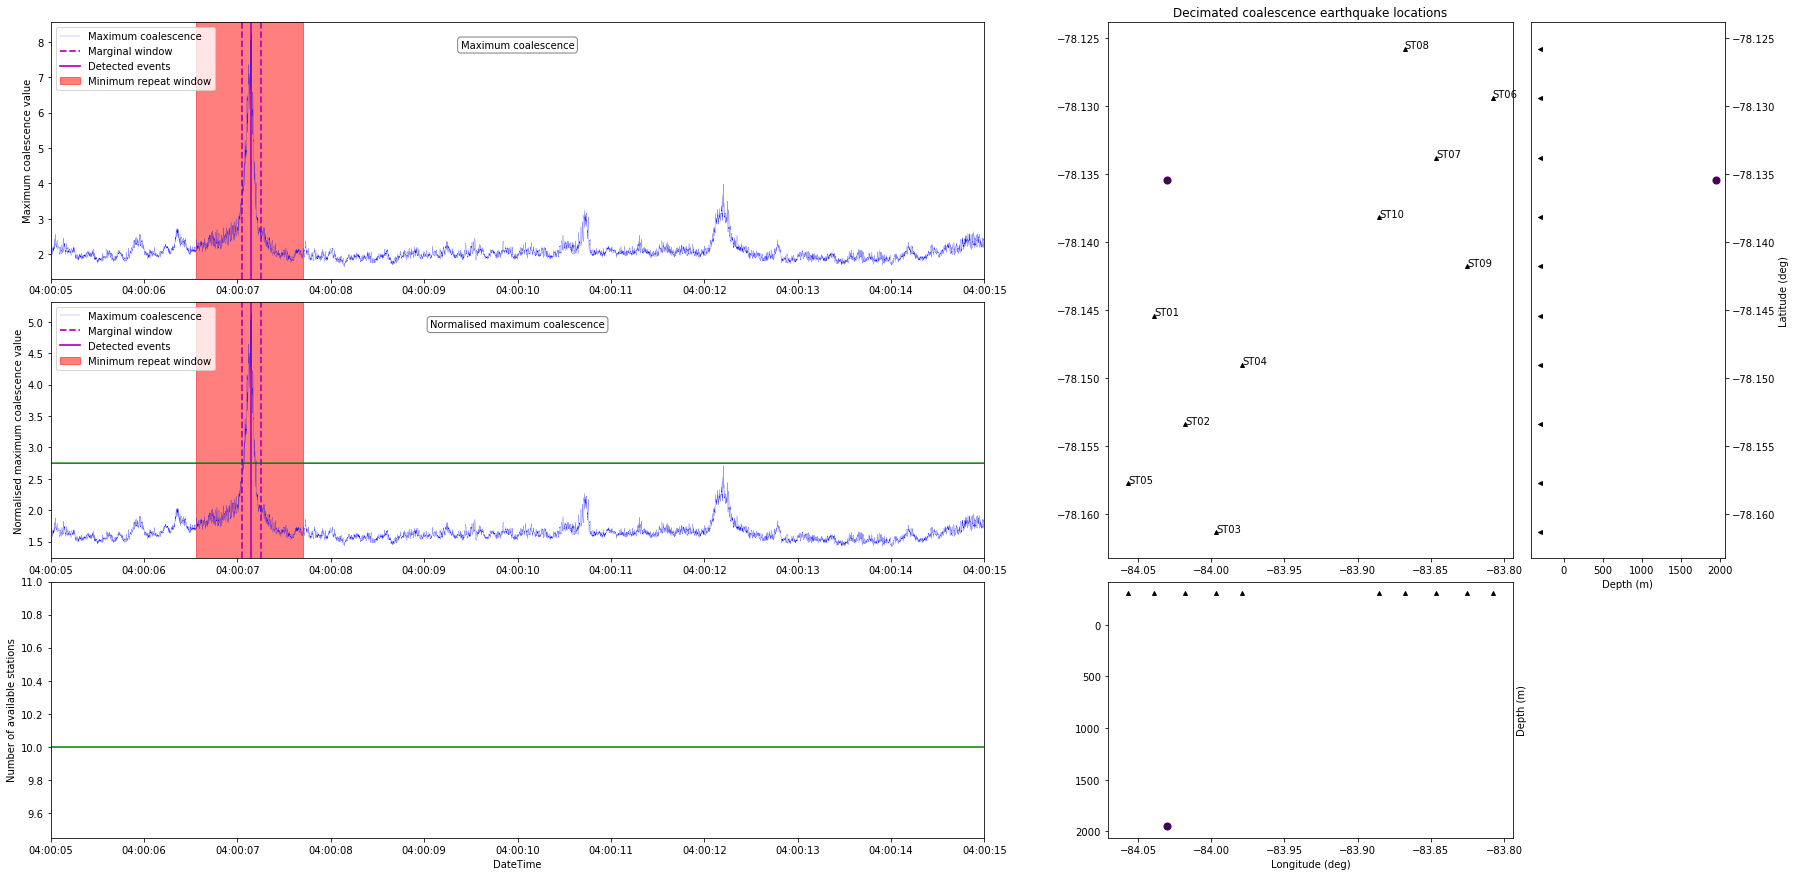

In [9]:
# --- Create new Trigger ---
trig = Trigger(out_path, run_name, stations)

# --- Set trigger parameters ---
trig.marginal_window = 0.1
trig.minimum_repeat = 0.5
trig.normalise_coalescence = True

# --- Static threshold ---
trig.detection_threshold = 2.75

# --- Run trigger ---
trig.trigger(start_time, end_time, savefig=True)

## 4. Run the locate stage, to relocate triggered events on a less decimated grid

In [14]:
# --- Create new PhasePicker ---
picker = GaussianPicker(onset=onset)
picker.marginal_window = 0.1
picker.plot_phase_picks = True

# --- Create new QuakeScan ---
scan = QuakeScan(data, lut, onset=onset, picker=picker,
                 output_path=out_path, run_name=run_name, log=True)

# --- Set locate parameters ---
scan.marginal_window = 0.1
scan.n_cores = 12
scan.sampling_rate = 1000

# Turn on plotting features
scan.plot_event_summary = True
scan.plot_event_video = False
scan.plot_station_traces = True

# --- Toggle writing of waveforms ---
scan.write_cut_waveforms = False

	QuakeMigrate - Coalescence Scanning - Path: outputs/runs - Name: icequake_example



In [15]:
# --- Run locate ---
scan.locate(start_time=start_time, end_time=end_time)

	LOCATE - Determining earthquake location and uncertainty

	Parameters:
		Start time     = 2009-01-21T04:00:05.000000Z
		End   time     = 2009-01-21T04:00:15.000000Z
		Number of CPUs = 12

	Onset parameters - using the classic STA/LTA onset
		Data sampling rate = 1000

		Bandpass filter P  = [20, 200, 4]
		Bandpass filter S  = [10, 125, 4]

		Onset P [STA, LTA] = [0.01, 0.25]
		Onset S [STA, LTA] = [0.05, 0.5]

	Pick parameters - using the 1-D Gaussian fit to onset
		Pick threshold = 1.0
		Search window  = 0.1s


	EVENT - 1 of 1 - 20090121040007151

	Determining event location...

	Reading waveform data...
    		Elapsed time: 0.327082 seconds.
	Computing 4D coalescence grid...
    		Elapsed time: 5.624697 seconds.
	Making phase picks...
    		Elapsed time: 0.125891 seconds.
	Determining earthquake location and uncertainty...
		Gridded loc: 27   59   23
		Spline  loc: 26.9 58.9 23.1
    		Elapsed time: 1.162265 seconds.
	Plotting event summary figure...
		Logo not plotting
    		Elapsed

## 5. Some of the key outputs

In [16]:
# Show the .event file, containing event origin time and location:
icequake_event_fname = "./outputs/runs/icequake_example/locate/events/20090121040007152.event"
event_df = pd.read_csv(icequake_event_fname)

event_df

,DT,COA,X,Y,Z,LocalGaussian_X,LocalGaussian_Y,LocalGaussian_Z,LocalGaussian_ErrX,LocalGaussian_ErrY,LocalGaussian_ErrZ,GlobalCovariance_X,GlobalCovariance_Y,GlobalCovariance_Z,GlobalCovariance_ErrX,GlobalCovariance_ErrY,GlobalCovariance_ErrZ,ML,ML_Err
0,2009-01-21T04:00:07.151000Z,3.391995,-83.930828,-78.143473,23.2,-84.029133,-78.136047,2005.540317,13.403505,27.848916,33.44127,-84.031605,-78.135591,2024.670755,48.27773,60.126091,95.835791,NaN,NaN


In [22]:
# Show the .picks file, containing station time picks:
icequake_pick_fname = "outputs/runs/icequake_example/locate/picks/20090121040007151.picks"
pick_df = pd.read_csv(icequake_pick_fname)

pick_df

,Name,Phase,ModelledTime,PickTime,PickError,SNR
0,ST01,P,2009-01-21T04:00:07.807875Z,2009-01-21T04:00:07.804628Z,0.017118,24.004905
1,ST01,S,2009-01-21T04:00:08.431740Z,-1,-1.000000,-1.000000
2,ST02,P,2009-01-21T04:00:07.939722Z,2009-01-21T04:00:07.937651Z,0.008168,25.095561
3,ST02,S,2009-01-21T04:00:08.688807Z,2009-01-21T04:00:08.695058Z,0.062021,10.333160
4,ST03,P,2009-01-21T04:00:08.125067Z,2009-01-21T04:00:08.118926Z,0.008977,24.981087
5,ST03,S,2009-01-21T04:00:09.050183Z,-1,-1.000000,-1.000000
6,ST04,P,2009-01-21T04:00:07.921087Z,2009-01-21T04:00:07.917593Z,0.030367,23.617772
7,ST04,S,2009-01-21T04:00:08.652475Z,2009-01-21T04:00:08.660640Z,0.058617,10.488054
8,ST05,P,2009-01-21T04:00:08.038745Z,2009-01-21T04:00:08.033220Z,0.012694,24.094823
9,ST05,S,2009-01-21T04:00:08.881878Z,-1,-1.000000,-1.000000


In [23]:
# Show the coalescence pdf file, containing event origin time and location:
icequake_coal_image_fname = "outputs/runs/icequake_example/locate/summaries/icequake_example_20090121040007152_EventSummary.pdf"
from IPython.display import IFrame # For plotting pdf
IFrame(icequake_coal_image_fname, width=800, height=400) # Plot pdf